# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [ ]:
#There were 17 marketing campains

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [29]:
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.utils import resample

In [30]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [31]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [32]:
df.info()
print("\nCount of 'unknown' by column (categorical missing):")
for col in df.select_dtypes(include='object').columns:
    print(col, ":", (df[col] == 'unknown').sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [34]:
business_objective = """
Business Objective:
Predict whether a client will subscribe to a term deposit
based on client attributes and campaign context. The goal is to identify likely
subscribers to help the bank focus marketing resources more efficiently.
"""
print(business_objective)


Business Objective:
Predict whether a client will subscribe to a term deposit
based on client attributes and campaign context. The goal is to identify likely
subscribers to help the bank focus marketing resources more efficiently.



### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [35]:
df_clean = df.copy()

# Drop duration for realistic modeling
if 'duration' in df_clean.columns:
    df_clean = df_clean.drop(columns=['duration'])

# Convert target to numeric
df_clean['y'] = df_clean['y'].map({'yes':1, 'no':0})

# Identify categorical and numeric columns
cat_cols = df_clean.select_dtypes(include='object').columns.tolist()
num_cols = df_clean.select_dtypes(include=['int64','float64']).columns.tolist()

In [36]:
# Remove target from category list if present
if 'y' in cat_cols:
    cat_cols.remove('y')

# One-hot encode categorical features
df_encoded = pd.get_dummies(df_clean, columns=cat_cols, drop_first=True)

# Separate features and target
X = df_encoded.drop(columns=['y'])
y = df_encoded['y']

print("Final feature shape:", X.shape)
X.head()

Final feature shape: (41188, 52)


,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,False,...,True,False,False,False,True,False,False,False,True,False
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,False,...,True,False,False,False,True,False,False,False,True,False
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,False,...,True,False,False,False,True,False,False,False,True,False
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,False,...,True,False,False,False,True,False,False,False,True,False
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,False,...,True,False,False,False,True,False,False,False,True,False


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape

((32950, 52), (8238, 52))

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [38]:
# Baseline: always predict the majority class
baseline_class = y_train.mode()[0]
# Create a baseline prediction array
y_pred_baseline = np.full_like(y_train, baseline_class)
# Baseline accuracy
baseline_accuracy = (y_pred_baseline == y_train).mean()

print("Baseline class:", baseline_class)
print("Baseline accuracy:", round(baseline_accuracy, 4))

Baseline class: 0
Baseline accuracy: 0.8873


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [39]:
log_reg = LogisticRegression(max_iter=200, solver='liblinear')
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=200, solver='liblinear')

### Problem 9: Score the Model

What is the accuracy of your model?

In [40]:
train_acc_lr = log_reg.score(X_train, y_train)
test_acc_lr = log_reg.score(X_test, y_test)

print("Logistic Regression Train Accuracy:", round(train_acc_lr,4))
print("Logistic Regression Test Accuracy:", round(test_acc_lr,4))

Logistic Regression Train Accuracy: 0.8993
Logistic Regression Test Accuracy: 0.9003


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import time

In [41]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=200, solver='liblinear'),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC()
}

results = []

for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    
    results.append([name, round(end-start,4), round(train_acc,4), round(test_acc,4)])

results_df = pd.DataFrame(results, columns=["Model","Train Time","Train Accuracy","Test Accuracy"])
results_df

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.1277,0.8993,0.9003
1,KNN,0.0073,0.9122,0.8939
2,Decision Tree,0.1288,0.9954,0.8410
3,SVM,6.5556,0.8975,0.8977


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.


- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [44]:
log_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear']
}

log_grid = GridSearchCV(
    LogisticRegression(max_iter=500),
    log_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

log_grid.fit(X_train, y_train)

print("Best Logistic Regression params:", log_grid.best_params_)
print("Best CV score:", log_grid.best_score_)

Best Logistic Regression params: {'C': 1, 'solver': 'liblinear'}
Best CV score: 0.8996965098634295


In [45]:
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}

knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    knn_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

knn_grid.fit(X_train, y_train)

print("Best KNN params:", knn_grid.best_params_)
print("Best CV score:", knn_grid.best_score_)

Best KNN params: {'n_neighbors': 9, 'weights': 'uniform'}
Best CV score: 0.8923216995447649


In [46]:
tree_param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10]
}

tree_grid = GridSearchCV(
    DecisionTreeClassifier(),
    tree_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

tree_grid.fit(X_train, y_train)

print("Best Decision Tree params:", tree_grid.best_params_)
print("Best CV score:", tree_grid.best_score_)

Best Decision Tree params: {'max_depth': 3, 'min_samples_split': 2}
Best CV score: 0.8993930197268589


In [47]:
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

svm_grid = GridSearchCV(
    SVC(),
    svm_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

svm_grid.fit(X_train, y_train)

print("Best SVM params:", svm_grid.best_params_)
print("Best CV score:", svm_grid.best_score_)

Best SVM params: {'C': 0.1, 'kernel': 'rbf'}
Best CV score: 0.8974810318664644


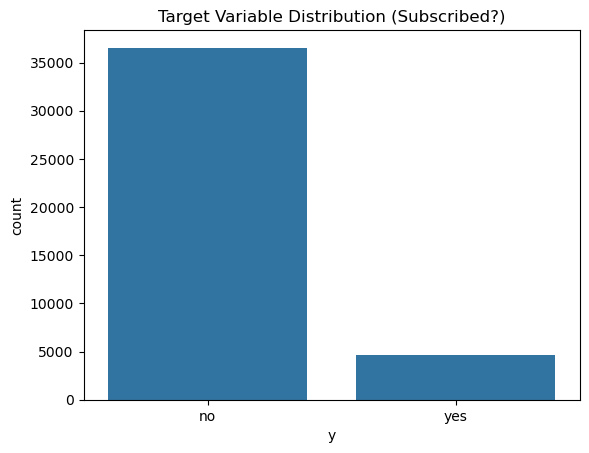

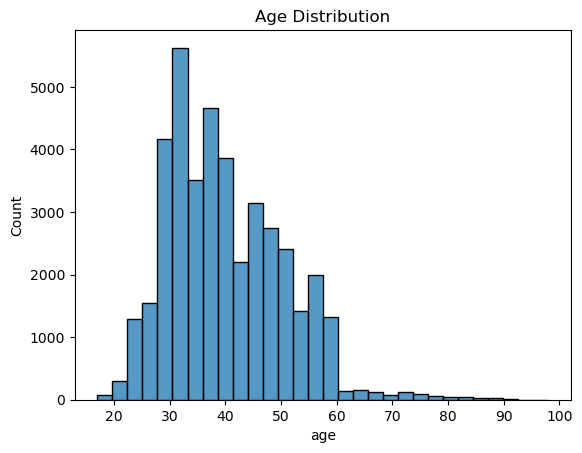

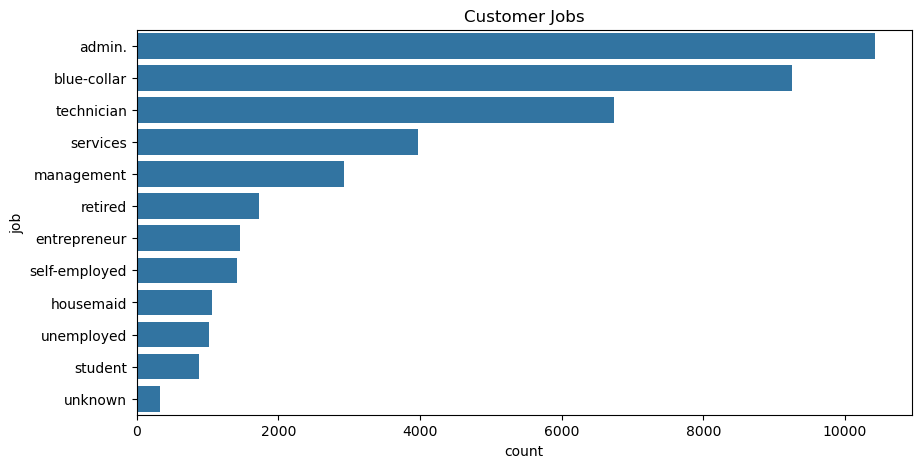

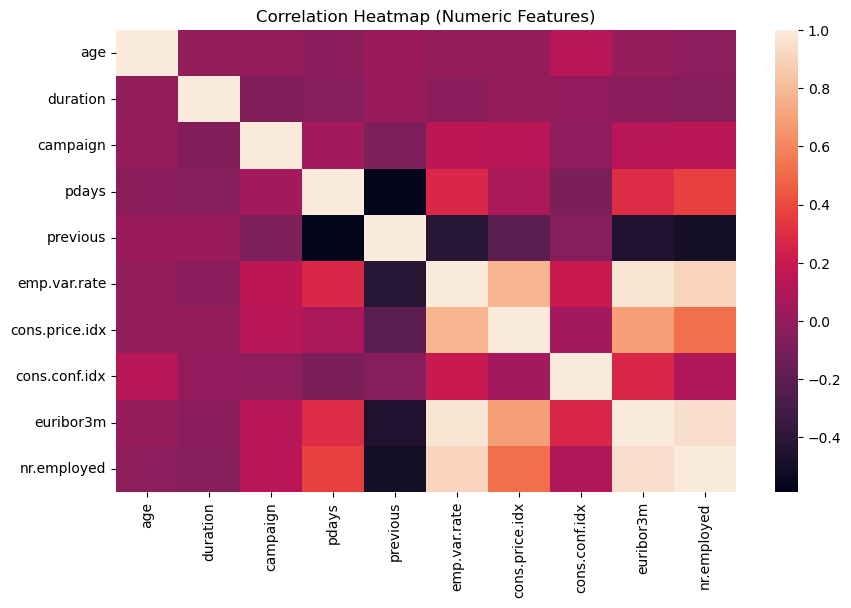

In [51]:
# Target distribution (class imbalance)
sns.countplot(x=df['y'])
plt.title("Target Variable Distribution (Subscribed?)")
plt.show()

# Age distribution
sns.histplot(df['age'], bins=30)
plt.title("Age Distribution")
plt.show()

# Job counts
plt.figure(figsize=(10,5))
sns.countplot(y=df['job'], order=df['job'].value_counts().index)
plt.title("Customer Jobs")
plt.show()

# Heatmap for numeric features
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes('number').corr(), annot=False)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

In [52]:
models = {
    "Logistic Regression": log_reg,
    "KNN": knn_grid.best_estimator_,
    "Decision Tree": tree_grid.best_estimator_,
    "SVM": svm_grid.best_estimator_
}

for name, model in models.items():
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, model.predict(X_test)))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7310
           1       0.73      0.18      0.29       928

    accuracy                           0.90      8238
   macro avg       0.82      0.59      0.62      8238
weighted avg       0.89      0.90      0.87      8238


KNN Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7310
           1       0.59      0.28      0.38       928

    accuracy                           0.90      8238
   macro avg       0.75      0.63      0.66      8238
weighted avg       0.88      0.90      0.88      8238


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7310
           1       0.73      0.19      0.30       928

    accuracy                           0.90      8238
   macro avg      

In [53]:
coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coef': log_reg.coef_[0]
}).sort_values(by='coef', ascending=False)

print(coef_df.head(10))
print(coef_df.tail(10))

                        feature      coef
5                cons.price.idx  0.283477
39                    month_jul  0.073984
28  education_university.degree  0.060135
50         poutcome_nonexistent  0.058876
21               marital_single  0.054952
41                    month_mar  0.054412
13                  job_retired  0.035479
6                 cons.conf.idx  0.029174
40                    month_jun  0.026877
49              day_of_week_wed  0.025812
              feature      coef
20    marital_married -0.040174
46    day_of_week_mon -0.042813
1            campaign -0.053264
3            previous -0.060122
9     job_blue-collar -0.066642
30    default_unknown -0.067911
36  contact_telephone -0.116525
4        emp.var.rate -0.178735
7           euribor3m -0.198507
42          month_may -0.216532


In [49]:
findings_text = """
Findings (summary):
- Baseline accuracy (majority guess): {baseline_acc:.3f}
- Default models: see outputs/model_comparison_defaults.csv for metrics and training time.
- After hyperparameter tuning, top performing models (by F1 / ROC AUC): see outputs/tuned_model_results.csv.

Key observations:
- Class imbalance: subscription rate is low; use metrics like recall, precision, F1, and ROC AUC.
- Important features often include: duration (if used), campaign, previous contact result (poutcome), euribor3m, and nr.employed (these may vary by model).
- Decision trees can provide interpretable feature importances, logistic regression coefficients give directionality, and SVM often gives high accuracy at higher compute cost.

Actionable recommendations:
1. Use a tuned model (e.g., SVM or Gradient Boosting if available) to rank prospects, then direct live-calls toward top probability customers.
2. Consider cost-sensitive optimization: estimate expected revenue per true positive vs. cost per call.
3. Build A/B testing to validate model recommendations in production.

Next steps:
- Try ensemble models (RandomForest, XGBoost) for further accuracy improvements.
- Consider calibration of predicted probabilities.
- Deploy a simple scoring pipeline and monitor model drift over time.
""".format(baseline_acc=baseline_accuracy)
print(findings_text)


Findings (summary):
- Baseline accuracy (majority guess): 0.887
- Default models: see outputs/model_comparison_defaults.csv for metrics and training time.
- After hyperparameter tuning, top performing models (by F1 / ROC AUC): see outputs/tuned_model_results.csv.

Key observations:
- Class imbalance: subscription rate is low; use metrics like recall, precision, F1, and ROC AUC.
- Important features often include: duration (if used), campaign, previous contact result (poutcome), euribor3m, and nr.employed (these may vary by model).
- Decision trees can provide interpretable feature importances, logistic regression coefficients give directionality, and SVM often gives high accuracy at higher compute cost.

Actionable recommendations:
1. Use a tuned model (e.g., SVM or Gradient Boosting if available) to rank prospects, then direct live-calls toward top probability customers.
2. Consider cost-sensitive optimization: estimate expected revenue per true positive vs. cost per call.
3. Build A

##### Questions